In [1]:
pip install selenium beautifulsoup4


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install PyPDF2


In [26]:
# ---- Imports ----
import os
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
import fitz  # PyMuPDF
from urllib.parse import urljoin
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# ---- Setup ----
HEADLESS = False
SAVE_PATH = "pwc_articles.csv"
options = Options()
if HEADLESS:
    options.add_argument("--headless=new")
options.add_argument("--start-maximized")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ---- PDF Download & Extract ----
def download_and_extract_pdf(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)"
                          " Chrome/90.0.4430.93 Safari/537.36"
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        with open("temp.pdf", "wb") as f:
            f.write(response.content)
        doc = fitz.open("temp.pdf")
        text = ""
        for page in doc:
            text += page.get_text()
        doc.close()
        os.remove("temp.pdf")
        return text
    except Exception as e:
        print(f" PDF extraction failed for {url}: {e}")
        return ""

# ---- Article Details Extraction ----
def extract_article_details(driver, article):
    try:
        driver.get(article["url"])
        time.sleep(4)

        soup = BeautifulSoup(driver.page_source, "html.parser")

        # Title fallback
        title = soup.find("h1")
        article["title"] = title.get_text(strip=True) if title else article["title"]

        # Date extraction from span#heroCsiMonth (if present)
        date_tag = soup.find("span", {"id": "heroCsiMonth"})
        if date_tag:
            article["date_published"] = date_tag.get_text(strip=True)
        elif not article.get("date_published"):
            article["date_published"] = ""

        # Extract all paragraphs content
        paragraphs = soup.find_all("p")
        article["content"] = "\n".join([p.get_text(strip=True) for p in paragraphs])

        # Find first PDF link in the page
        pdf_link = None
        for a_tag in soup.find_all("a", href=True):
            href = a_tag['href']
            if href.lower().endswith(".pdf"):
                pdf_link = urljoin(article["url"], href)
                break

        if pdf_link:
            article["pdf_url"] = pdf_link
            try:
                article["pdf_content"] = download_and_extract_pdf(pdf_link)
                print(f"📄 PDF extracted for: {article['title']}")
            except Exception as e:
                article["pdf_content"] = ""
                print(f" PDF error: {e}")
        else:
            article["pdf_url"] = ""
            article["pdf_content"] = ""

        print(f" Done: {article['title']}")
    except Exception as e:
        print(f" Error processing {article.get('url', '')}: {e}")

# ---- Main Scraping Logic ----
base_url = "https://www.pwc.com/gx/en/research-insights.html"
driver.get(base_url)
time.sleep(5)

# Click Load More button up to 2 times
max_load_more_clicks = 2
click_count = 0
while click_count < max_load_more_clicks:
    try:
        load_more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "button.collection__load-more"))
        )
        driver.execute_script("arguments[0].click();", load_more_button)
        time.sleep(4)
        click_count += 1
        print(f"Load More clicked {click_count} times")
    except Exception as e:
        print("No more Load More button or error:", e)
        break

# Extract article tiles
tiles = driver.find_elements(By.CSS_SELECTOR, "article.feedItem.ng-scope")
print(f" Found {len(tiles)} article tiles.")

articles = []
for tile in tiles:
    try:
        a_tag = tile.find_element(By.TAG_NAME, "a")
        url = a_tag.get_attribute("href")

        tile_html = tile.get_attribute("outerHTML")
        soup = BeautifulSoup(tile_html, "html.parser")

        # Extract date and title from tile
        time_tag = soup.select_one("p.collection__item-sub-heading time")
        date_text = time_tag.get_text(strip=True) if time_tag else ""

        title_tag = soup.select_one("h4.collection__item-heading span")
        title_text = title_tag.get_text(strip=True) if title_tag else ""

        if url and url not in [a["url"] for a in articles]:
            articles.append({
                "title": title_text,
                "url": url,
                "date_published": date_text
            })
    except Exception as e:
        print(f" Tile error: {e}")

print(f" Total articles found: {len(articles)}")

# Extract full content + pdfs
for article in articles:
    extract_article_details(driver, article)

driver.quit()

# Save to CSV
df = pd.DataFrame(articles)
df.to_csv(SAVE_PATH, index=False)
print(f"\n All done. Saved to: {SAVE_PATH}")


Load More clicked 1 times
Load More clicked 2 times
 Found 24 article tiles.
 Total articles found: 23
 Done: How we feed ourselves
 Done: How we move
 Done: Episode 113: Tax Policy in Transition: From D.C. to the OECD — What to expect in 2025
 Done: Using actionable intelligence to build cohesion across a diverse business
 Done: Building supply chain resilience through technology-enabled data sharing
 Done: Ep. 29: Thriving Amidst Change: Reinventing ​Business Models for Resilience​
 Done: Episode 112: Special Edition – Financial Transactions Transfer Pricing
 Done: Global M&A Industry Trends in Technology, Media & Telecommunications
 Done: Global M&A Trends in Health Industries
 PDF extraction failed for https://publications.iadb.org/es/publications/spanish/viewer/Fintech-en-America-Latina-y-el-Caribe-un-ecosistema-consolidado-con-potencial-para-aportar-a-la-inclusion-fianciera-regional.pdf: 403 Client Error: Forbidden for url: https://publications.iadb.org/es/publications/spanish/vi

# Part 2

In [19]:
# ---- PwC Insights Comparative Analysis ----
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import umap
import hdbscan

# ---- Load and Combine Text ----
df = pd.read_csv("pwc_articles.csv")
df["full_text"] = df["content"].fillna("") + " " + df.get("pdf_content", "").fillna("")

# ---- Text Cleaning ----
custom_stopwords = set("a an the and is in it for to of with on that this as by at from or be are".split())
def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]", " ", text)
    tokens = re.findall(r'\b\w{3,}\b', text.lower())
    filtered = [word for word in tokens if word not in custom_stopwords]
    return " ".join(filtered)
df["clean_text"] = df["full_text"].apply(clean_text)

# ---- Rule-based Topic Classification ----
topic_keywords = {
    "ESG": ["esg", "sustainability", "carbon", "net zero"],
    "Supply Chain": ["logistics", "supply chain", "inventory"],
    "Cyber security": ["cyber", "security", "ransomware", "hacking"],
    "Workforce": ["employee", "workforce", "hr", "talent", "hiring"],
    "Artificial Intelligence": ["ai", "artificial intelligence", "machine learning"],
    "Technology": ["technology", "digital", "software", "platform"],
    "Risk and Regulation": ["regulation", "compliance", "risk", "policy"],
    "Transformation": ["transformation", "change", "innovation"],
    "GCC": ["gcc", "global capability center", "shared service"],
    "Economy and Growth": ["gdp", "economy", "growth", "inflation"],
    "Energy and Renewables": ["solar", "wind", "renewables", "energy"],
    "Trade and tariffs": ["trade", "tariff", "exports", "imports"],
}
def classify_topic(text):
    for topic, keywords in topic_keywords.items():
        if any(kw in text.lower() for kw in keywords):
            return topic
    return "Other"
df["topic"] = df["clean_text"].apply(classify_topic)

# ---- TF-IDF Keyword Extraction ----
tfidf = TfidfVectorizer(max_features=50)
X_tfidf = tfidf.fit_transform(df["clean_text"])
keywords = tfidf.get_feature_names_out()
top_indices = X_tfidf.toarray().argsort(axis=1)[:, -5:]
df["top_keywords"] = [[keywords[i] for i in row if i < len(keywords)] for row in top_indices]

# ---- Semantic Topic Classification ----
semantic_topics = list(topic_keywords.keys())
model = SentenceTransformer("all-MiniLM-L6-v2")
topic_embeddings = model.encode(semantic_topics)
article_embeddings = model.encode(df["clean_text"].tolist())
def classify_semantic(embedding):
    sims = cosine_similarity([embedding], topic_embeddings)[0]
    return semantic_topics[np.argmax(sims)]
df["classified_topic"] = [classify_semantic(e) for e in article_embeddings]

# ---- UMAP + HDBSCAN Clustering ----
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(article_embeddings)
cluster_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
df["cluster"] = cluster_model.fit_predict(umap_embeddings)

# ---- Extract Cluster Keywords ----
def extract_keywords(texts, top_n=5):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    top_keywords = X.toarray().mean(axis=0).argsort()[::-1][:top_n]
    return [keywords[i] for i in top_keywords]
cluster_labels = {}
for c in sorted(df["cluster"].unique()):
    cluster_texts = df[df["cluster"] == c]["clean_text"].tolist()
    cluster_labels[c] = extract_keywords(cluster_texts)
df["cluster_keywords"] = df["cluster"].map(cluster_labels)

# ---- Save Enriched Data ----
df.to_csv("pwc_articles_enriched.csv", index=False)
print("✅ Enriched data saved to pwc_articles_enriched.csv")


C:\Users\prana\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✅ Enriched data saved to pwc_articles_enriched.csv


C:\Users\prana\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Part 3

In [20]:
pip install pandas plotly dash


   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/7.9 MB 13.4 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/7.9 MB 16.7 MB/s eta 0:00:01
   ---------------------------------------- 7.9/7.9 MB 16.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


 Total Articles: 23
 Unique Topics: 5
 Unique Clusters: 3

 Topic Distribution:
classified_topic
Supply Chain             9
Trade and tariffs        6
Energy and Renewables    4
Risk and Regulation      2
Workforce                2
Name: count, dtype: int64

 Top Keywords: [('menu', 23), ('pwc', 14), ('you', 10), ('global', 7), ('these', 7), ('deals', 7), ('cookies', 6), ('will', 5), ('think', 5), ('deal', 4)]


C:\Users\prana\AppData\Local\Temp\ipykernel_18844\410894725.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




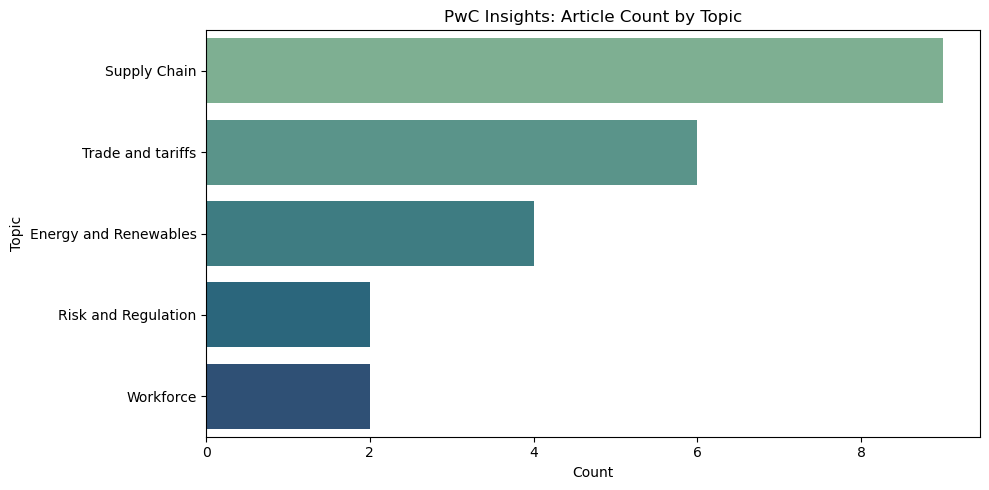

C:\Users\prana\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\prana\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



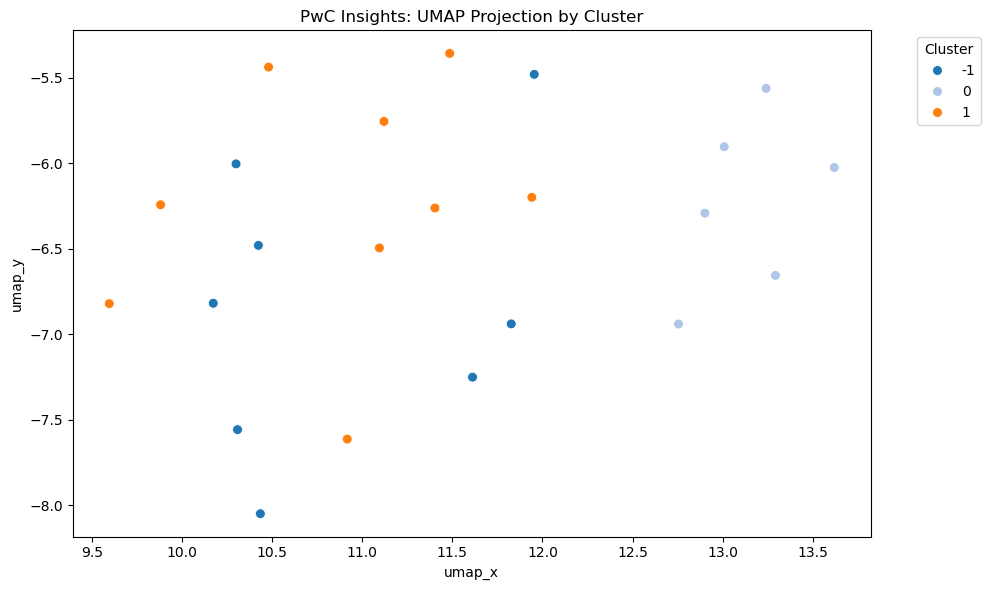

In [25]:
# ---- Imports ----
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sentence_transformers import SentenceTransformer
import umap
import ast

# ---- Load PwC Enriched Data ----
df = pd.read_csv("pwc_articles_enriched.csv")

# ---- Fix list-like columns ----
df["top_keywords"] = df["top_keywords"].apply(ast.literal_eval)
df["cluster_keywords"] = df["cluster_keywords"].apply(ast.literal_eval)

# ---- Summary Statistics ----
print(" Total Articles:", len(df))
print(" Unique Topics:", df["classified_topic"].nunique())
print(" Unique Clusters:", df["cluster"].nunique())
print("\n Topic Distribution:")
print(df["classified_topic"].value_counts())

# ---- Top 10 Keywords in Corpus ----
keyword_counts = Counter([kw for kws in df["top_keywords"] for kw in kws])
print("\n Top Keywords:", keyword_counts.most_common(10))

# ---- Topic Distribution Bar Plot ----
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y="classified_topic", order=df["classified_topic"].value_counts().index, palette="crest")
plt.title("PwC Insights: Article Count by Topic")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

# ---- UMAP Embedding for Cluster Visualization ----
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["clean_text"].tolist(), show_progress_bar=True)

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_proj = umap_model.fit_transform(embeddings)

df["umap_x"] = umap_proj[:, 0]
df["umap_y"] = umap_proj[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="umap_x", y="umap_y", hue="cluster", palette="tab20", s=50)
plt.title("PwC Insights: UMAP Projection by Cluster")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---- WordCloud for a Cluster ----
def show_wordcloud(cluster_id):
    keywords = df[df["cluster"] == cluster_id]["cluster_keywords"].explode().dropna().tolist()
    if not keywords:
        print(f" No keywords for cluster {cluster_id}")
        return
    text = " ".join(keywords)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_
